In [39]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

In [40]:
img_size = (28, 28)
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

In [41]:
train_ds, val_ds, test_ds = tfds.load('mnist', split=['train[:80%]', 'test[:10%]', 'test[:10%]'], shuffle_files=True, as_supervised=True)

In [42]:
rescale = tf.keras.Sequential([
    layers.Rescaling(1./255)
])

In [43]:
def prepare(ds: tf.data.Dataset):
    ds = ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).shuffle(1024).prefetch(AUTOTUNE).cache()
    return ds

In [44]:
train_ds = prepare(train_ds)
test_ds = prepare(test_ds)
val_ds = prepare(val_ds)

In [45]:
def show_batch(images, labels, pred_labels=None, num=25):
    font_dict = {'color': 'black'}
    fig = plt.figure(figsize=(20, 10))
    for i in range(num):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(images[i])

        title = labels[i]
        if (pred_labels is not None):
            if (labels[i] == np.argmax(pred_labels[i])):
                font_dict['color'] = 'green'
            else:
                font_dict['color'] = 'red'
        
        plt.title(title, fontdict=font_dict)
        plt.axis("off")

In [46]:
train_iter = train_ds.as_numpy_iterator()

In [47]:
images, labels = train_iter.next()

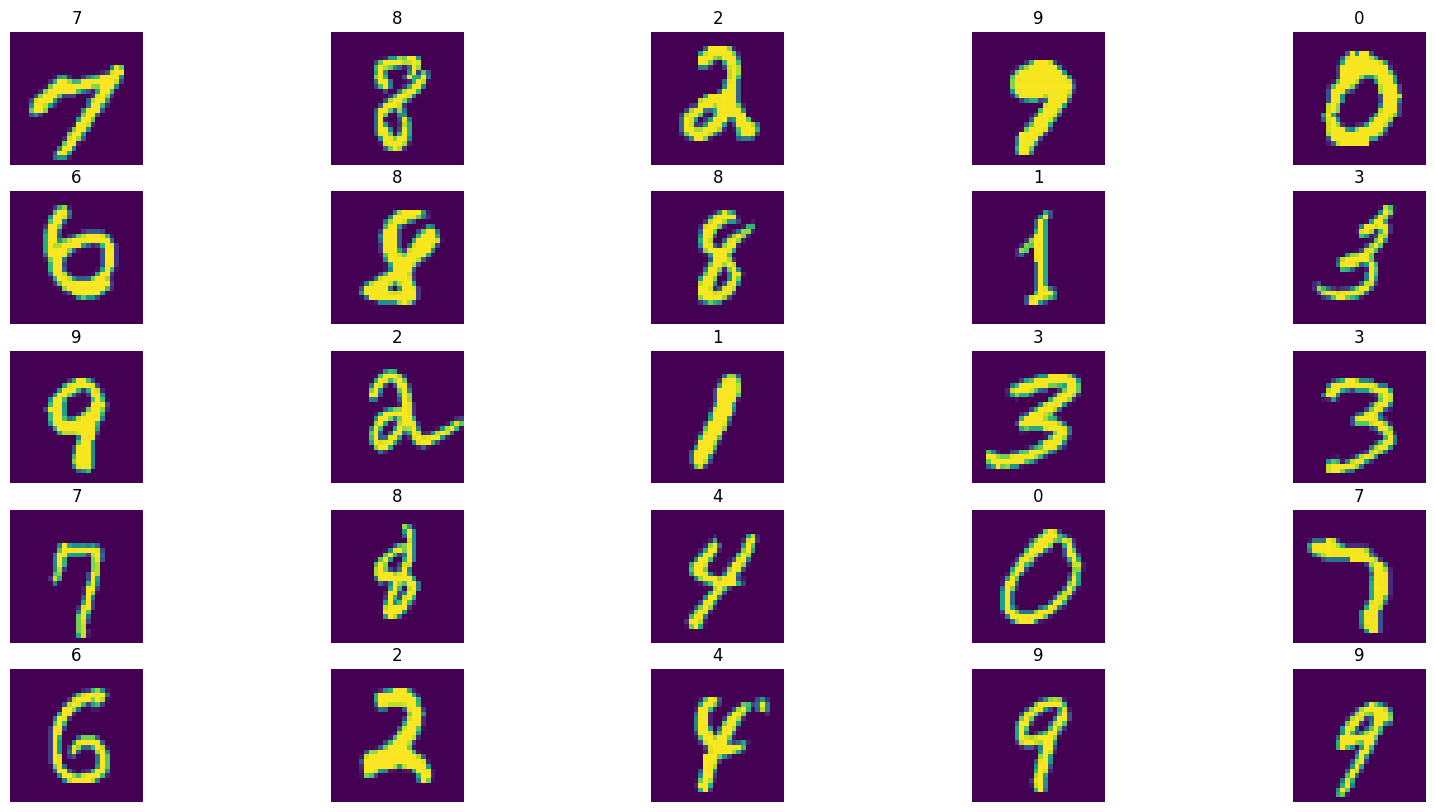

In [48]:
show_batch(images, labels)

## DL Model

In [54]:
model = keras.Sequential([
    layers.Conv2D(32, 3, activation="relu", padding='same', input_shape=(28, 28, 1)),
    layers.Conv2D(32, 3, activation="relu", padding='same'),
    layers.MaxPooling2D(2),
    layers.BatchNormalization(),

    layers.Conv2D(64, 3, activation="relu", padding='same'),
    layers.Conv2D(64, 3, activation="relu", padding='same'),
    layers.MaxPooling2D(2),
    layers.BatchNormalization(),
    
    layers.GlobalAveragePooling2D(),

    layers.Flatten(),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.3),

    layers.Dense(10, activation="softmax")
])

In [55]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 64)       

In [56]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [57]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("model/mnist_model.h5")
]

In [58]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=callbacks)

Epoch 1/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1781 - accuracy: 0.9468 - val_loss: 0.0924 - val_accuracy: 0.9680
Epoch 2/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0522 - accuracy: 0.9840 - val_loss: 0.0667 - val_accuracy: 0.9790
Epoch 3/50
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0371 - accuracy: 0.9890 - val_loss: 0.0780 - val_accuracy: 0.9790
Epoch 4/50
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0296 - accuracy: 0.9908 - val_loss: 0.0844 - val_accuracy: 0.9790
Epoch 5/50
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0256 - accuracy: 0.9915 - val_loss: 0.0635 - val_accuracy: 0.9830
Epoch 6/50
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0202 - accuracy: 0.9936 - val_loss: 0.0612 - val_accuracy: 0.9870
Epoch 7/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0180 - accuracy: 0.9937 - val_loss: 0.0351 - val_accuracy:

In [59]:
model.evaluate(test_ds)

32/32 [==============================] - 1s 2ms/step - loss: 0.0220 - accuracy: 0.9910


[0.022046878933906555, 0.9909999966621399]

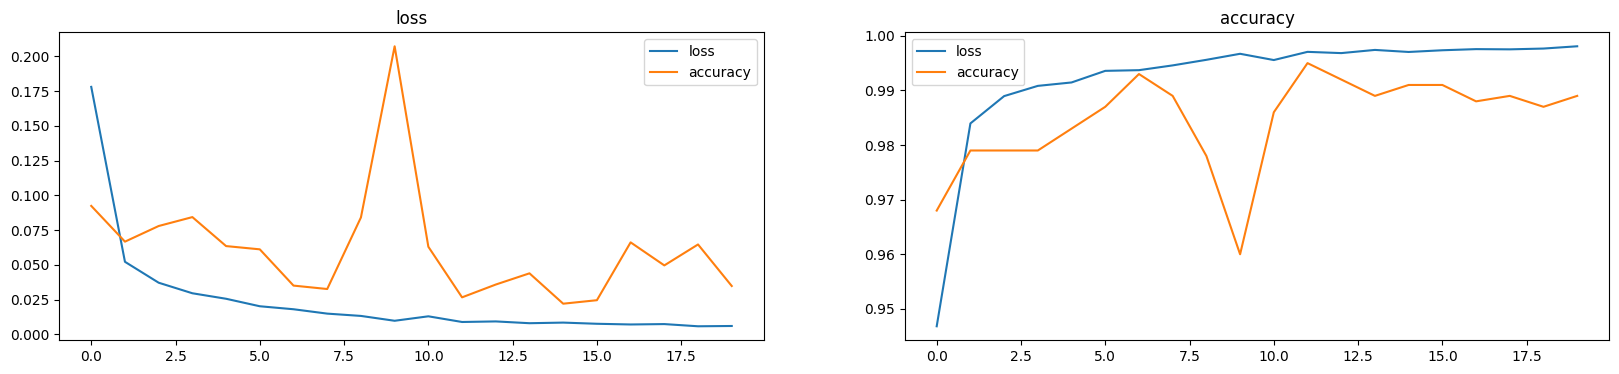

In [60]:
metrics = ['loss', 'accuracy']

fig, ax = plt.subplots(ncols=len(metrics), figsize=(20, 4))
for i, metric in enumerate(metrics):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_"+metric])

    ax[i].legend(metrics)
    ax[i].set_title(metric)

In [61]:
test_iter = test_ds.as_numpy_iterator()

In [65]:
test_images, test_labels = test_iter.next()

In [66]:
pred_labels = model.predict(test_images)

1/1 [==============================] - 0s 17ms/step


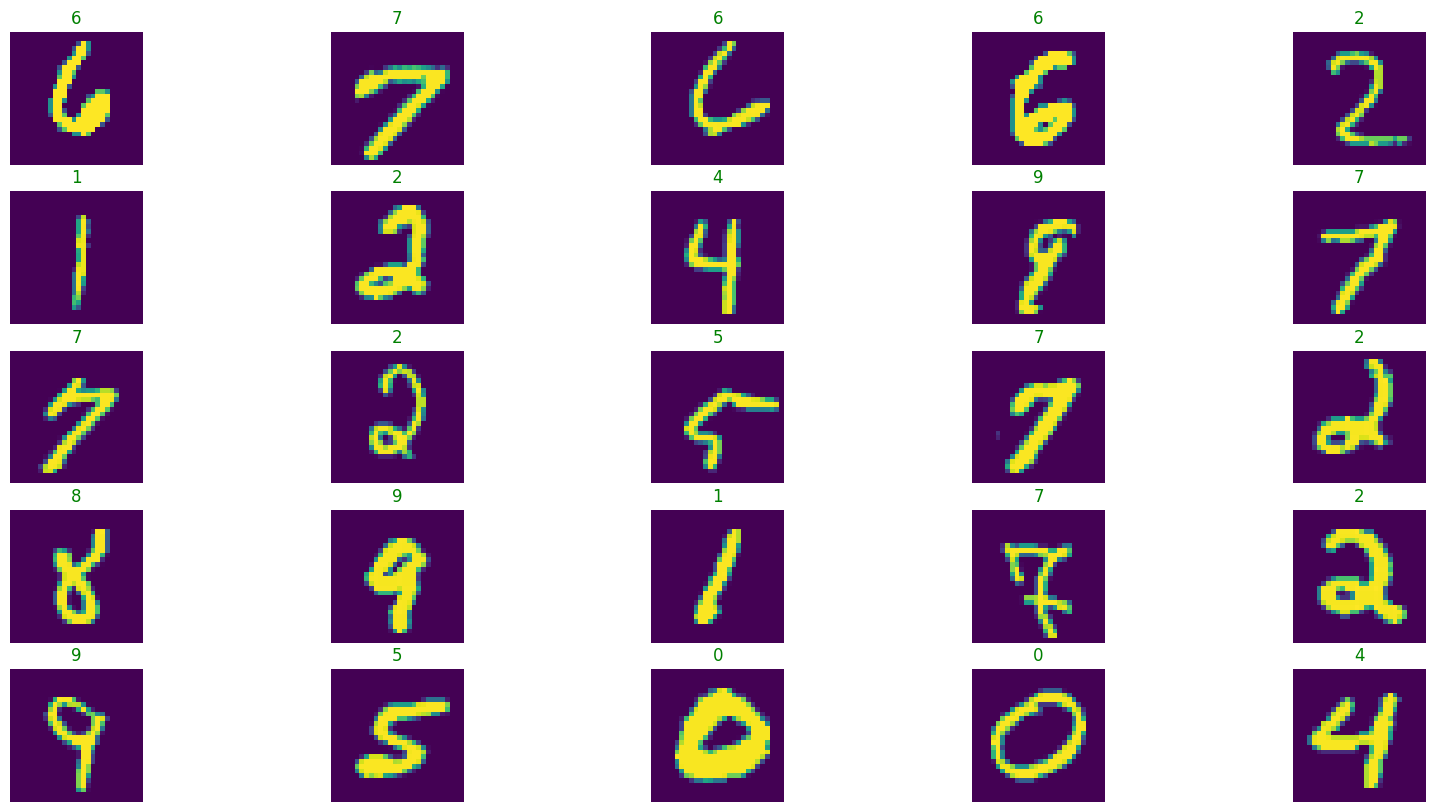

In [67]:
show_batch(test_images, test_labels, pred_labels)

In [68]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [80]:
y_pred = model.predict(test_ds)
y_pred = np.array([np.argmax(y) for y in y_pred])

32/32 [==============================] - 0s 6ms/step


In [74]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)

In [82]:
cm = confusion_matrix(y_true, y_pred)

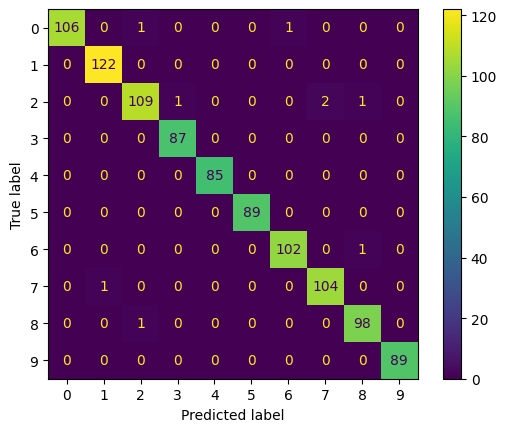

In [85]:
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [91]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       108
           1       0.99      1.00      1.00       122
           2       0.98      0.96      0.97       113
           3       0.99      1.00      0.99        87
           4       1.00      1.00      1.00        85
           5       1.00      1.00      1.00        89
           6       0.99      0.99      0.99       103
           7       0.98      0.99      0.99       105
           8       0.98      0.99      0.98        99
           9       1.00      1.00      1.00        89

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

